In [1]:
import os
import glob
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from utility.utility import *
from utility.algorithm import *

In [2]:
def import_files(path, dtype):
    '''
    Import files in the syntax that I used in the notebook. That is, choose the path that contains
    all the files, then obtain all dat and inf files as dictionaries that can be accessed by filename. 
    '''

    filename = "*.dat"
    files =  [ p for p in Path(path).glob(filename) ]
    file_dict = dict()
    for file in files:
        with open(file, 'rb') as f:
            # key of the dict is the filename, value the data.
            file_dict[os.path.basename(file)] = np.fromfile(f, np.float32)

    metadata_dict = dict()
    filename = "*.inf"
    files =  [ p for p in Path(path).glob(filename) ]
    for file in files:
        with open(file) as f:
            metadata_dict[os.path.basename(file)] = f.readlines()

    return file_dict, metadata_dict 

In [3]:
data_dict, metadata_dict = import_files(path="../../LOFAR_2e_jaars_RP_2022_voor_studenten/Data_Pulsar2", dtype="float32")
nbins_dict = dict()
dt_dict = dict()
mjd_dict = dict()
for key, val in metadata_dict.items():
    nbins_dict[key] = int(get_metadata_item(metadata_dict[key], 'Number of bins in the time series'))
    dt_dict[key] = float(get_metadata_item(metadata_dict[key], 'Width of each time series bin (sec)'))
    mjd_dict[key] = float(get_metadata_item(metadata_dict[key], 'Epoch of observation (MJD)'))

In [16]:
# use fitresults mathematica to make function 
x_range = [number for number in np.arange(0.20+ 5.63e4, 0.50 + 5.63e4, 0.001)]
B = 0.00166275
A = -7.81285 * 10 **-8
omega = -41.3487
phi = 117036

#create y values
sine_fit = [B + A * np.sin(omega*number + phi) for number in x_range]

# errors from fit
B_err = 8.0565e-10
A_err = 1.12952e-9
omega_err = 0.399323
phi_err = 22482.1

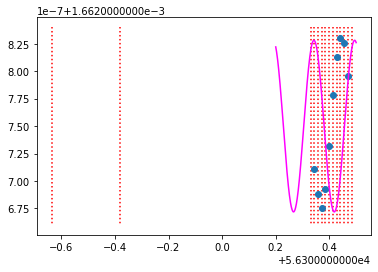

In [17]:
# working data from mathematica that is from python
x = [56300.4688155539, 56300.45492639893, 56300.44103724313, 56300.42714808649, 56300.413258929024, 56300.39936977075, 56300.38548061164, 56300.37159145176, 56300.35770229113, 56300.34381312978]
y = [0.0016627957592090326, 0.00166282563896264, 0.0016628302415629193, 0.0016628131097909669, 0.0016627781654799023, 0.0016627323139534107, 0.0016626925155149316, 0.0016626750457100386, 0.0016626881480292916, 0.001662710837899844]
err = [2.353097663263867e-9, 2.3435228659575588e-9, 2.2291472249414805e-9, 1.9880488969239098e-9, 3.1889485827440945e-9, 3.46808484243367e-9, 2.1726783415015955e-9, 5e-9, 2.2821954279209845e-9, 3.615634992325844e-9]

list_MJD_All =  list( mjd_dict.values() )
# lines datapoints 
ymin = 8.4e-7 + 1.662e-3
ymax = 6.6e-7 + 1.662e-3
plt.vlines(list_MJD_All, ymin, ymax, colors='red', linestyles='dotted')
plt.plot(x,y, 'o')
plt.plot(x_range, sine_fit, color='magenta')

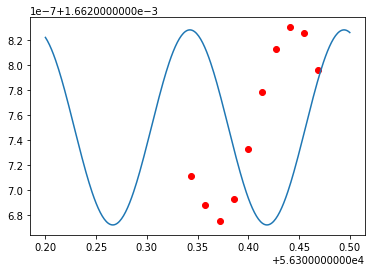

In [15]:
plt.plot(x,y, 'o', color='red')
plt.plot(x_range, sine_fit)
